In [1]:
import numpy as np
import cv2
import pandas as pd
import os
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-05-01 17:01:01.454575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 17:01:01.454677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 17:01:01.571498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load your data - modify this based on your data structure
base_path = '/kaggle/input/face-data-new/New'
labels_file_path = '/kaggle/input/face-data-new/label_N.csv'

# Load labels from CSV
df = pd.read_csv(labels_file_path)

In [3]:
df

,image_name,gender,height,weight
0,0001.jpg,1,162.56,61
1,0002.jpg,1,162.56,65
2,0003.jpg,1,162.56,79
3,0004.jpg,1,167.64,74
4,0005.jpg,1,165.10,54
...,...,...,...,...
2905,2906.jpg,0,172.72,151
2906,2907.jpg,0,172.72,88
2907,2908.jpg,0,177.80,81
2908,2909.jpg,0,182.88,114


In [4]:
# Load and preprocess image function
def load_and_preprocess_image(image_name, label, target_size=(128, 128)):
    image = cv2.imread(image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image, label

In [5]:
# Load image names and labels
X_names = df['image_name'].apply(lambda x: os.path.join(base_path, x)).values
Y = df[['gender', 'height', 'weight']].values

# Load and preprocess the images
X_images = []
for image_name, label in zip(X_names, Y):
    processed_image, processed_label = load_and_preprocess_image(image_name, label)
    X_images.append(processed_image)

# Convert the lists to NumPy arrays
X_data = np.array(X_images, dtype=np.float32)
Y_data = np.array(Y, dtype=np.float32)


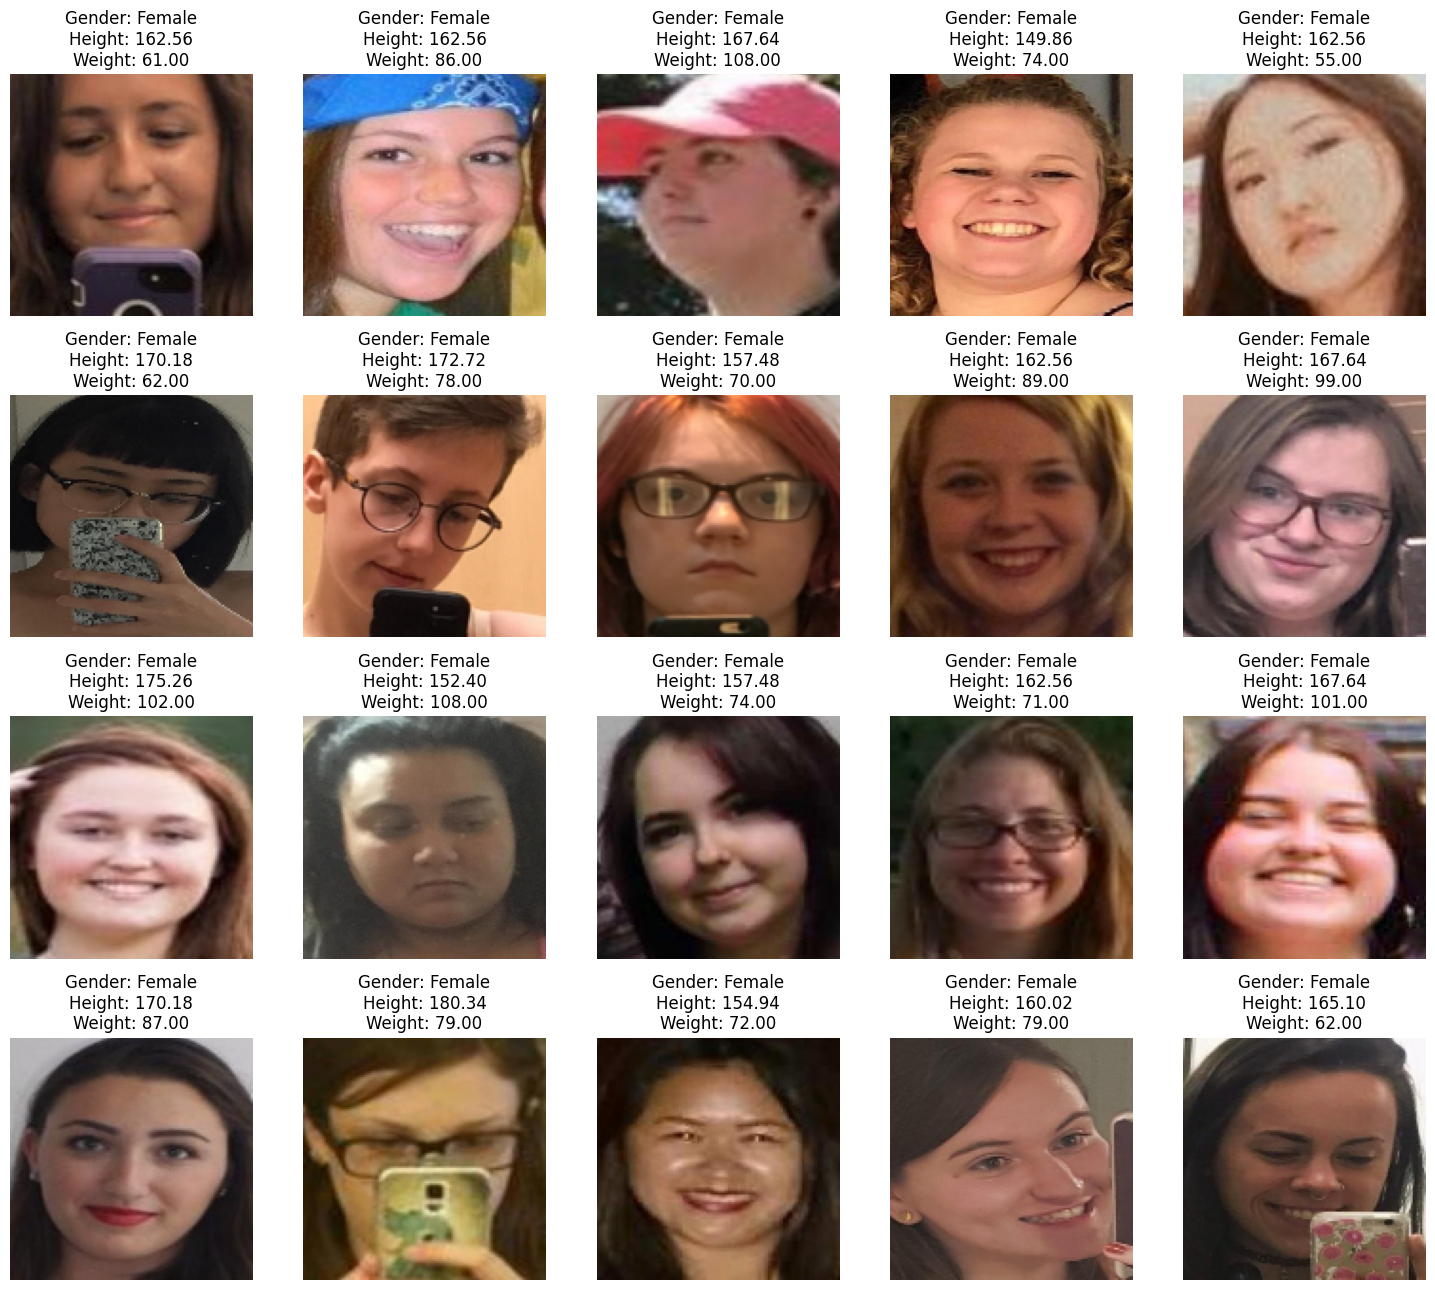

In [6]:
# Visualization code
# Starting index and the gap between images
start_index = 0
gap = 25
num_images_to_visualize = 20

# Calculate the number of rows and columns for a better layout
num_rows = 4
num_cols = 5

# Visualize the specified images with labels
plt.figure(figsize=(15, 13))
for i in range(num_images_to_visualize):
    index = start_index + i * gap
    gender_label = "Male" if Y_data[index][0] == 0 else "Female"
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_data[index])
    plt.title(
        f"Gender: {gender_label}\nHeight: {Y_data[index][1]:.2f}\nWeight: {Y_data[index][2]:.2f}"
    )
    plt.axis('off')

# Add space between subplots vertically
plt.subplots_adjust(hspace=0.5)

plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented data
augmented_images = []
augmented_labels = []

for i in range(5):
    # Create a generator from the original data
    generator = datagen.flow(X_data, Y_data, batch_size=len(X_data), shuffle=True)
    
    # Generate augmented data batch
    X_batch, Y_batch = next(generator)
    
    # Append to the augmented data list
    augmented_images.append(X_batch)
    augmented_labels.append(Y_batch)

# Concatenate the augmented data
X_augmented = np.concatenate(augmented_images, axis=0)
Y_augmented = np.concatenate(augmented_labels, axis=0)

# Mix original and augmented data
mixed_images = np.concatenate([X_data, X_augmented], axis=0)
mixed_labels = np.concatenate([Y_data, Y_augmented], axis=0)

# Show the total number of images
print("Total number of images:", len(mixed_images))


Total number of images: 17460


In [8]:
from sklearn.model_selection import train_test_split

# Split the augmented data into training and test sets with a 70-30 split
X_train, X_test, Y_train, Y_test = train_test_split(X_augmented, Y_augmented, test_size=0.3, random_state=42)

# Split the test set into validation and test sets with a 50-50 split
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the sizes of the resulting sets
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 10185
Validation set size: 2182
Test set size: 2183


Propsed Model

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Define the input shape
input_shape = (128, 128, 3)

# Input layer
input_layer = Input(shape=input_shape)

# Convolutional layers with batch normalization and max pooling
x = Conv2D(64, (3, 3))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)


# Flatten layer
x = Flatten()(x)

# Dense layers with dropout
x = Dense(2048)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)  # Adjusted dropout rate

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)  # Adjusted dropout rate

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.01)(x)  # Adjusted dropout rate

x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.01)(x)  # Adjusted dropout rate


combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=combined_output)


# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

Epoch 1/200
  3/319 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.1343 - loss: 87.8485 - mape: 86.5676 - rmse: 113.4727   

I0000 00:00:1714582992.785633      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714582992.810149      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2116 - loss: 84.9028 - mape: 78.8384 - rmse: 110.2988

W0000 00:00:1714583014.519510      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714583016.499106      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.2118 - loss: 84.8932 - mape: 78.8223 - rmse: 110.2878 - val_accuracy: 0.3313 - val_loss: 75.5161 - val_mape: 66.8679 - val_rmse: 99.4963
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.3751 - loss: 71.3078 - mape: 62.4874 - rmse: 94.9562 - val_accuracy: 0.4826 - val_loss: 50.9735 - val_mape: 51.7395 - val_rmse: 72.3115
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5295 - loss: 52.0939 - mape: 47.0547 - rmse: 73.6218 - val_accuracy: 0.5813 - val_loss: 44.5121 - val_mape: 41.8659 - val_rmse: 64.1438
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.6458 - loss: 34.6414 - mape: 35.4172 - rmse: 50.8287 - val_accuracy: 0.7129 - val_loss: 26.4255 - val_mape: 28.7081 - val_rmse: 38.0944
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7363 - loss: 20.9810 - mape: 26.3750 - rmse: 30.4027 - val_accuracy: 0.7869 - val_loss: 14.6129 - val_mape: 21.3144 - val_

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8829 - loss: 7.5848 - mape: 11.7138 - rmse: 14.3972
27/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

W0000 00:00:1714585446.746722      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Gender Test MAE: 0.18405211490608386
Height Test MAE: 6.625589962241522
Weight Test MAE: 16.149829840037565
Gender Test MAPE: 14.290223220483567
Height Test MAPE: 3.8569768758760814
Weight Test MAPE: 17.050437100146773
Gender Test RMSE: 0.35663437808283444
Height Test RMSE: 8.544621027232692
Weight Test RMSE: 23.631583581001056
Gender Test Accuracy: 0.8570977677951643
Height Test Accuracy: 0.9614302312412392
Weight Test Accuracy: 0.8294956289985322


ResNet50

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

from tensorflow.keras.applications import ResNet50

# Define the input shape
input_shape = (128, 128, 3)

# Load the ResNet50 base model pretrained on ImageNet
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet50_base.trainable = False

# Create a new model by adding a single dense layer for gender, height, and weight prediction
x = Flatten()(resnet50_base.output)
combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=resnet50_base.input, outputs=combined_output)


# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.3050 - loss: 76.2661 - mape: 69.5026 - rmse: 100.4666 - val_accuracy: 0.5876 - val_loss: 44.0464 - val_mape: 41.2427 - val_rmse: 64.2303
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6297 - loss: 37.0187 - mape: 37.0261 - rmse: 54.3454 - val_accuracy: 0.7341 - val_loss: 19.4906 - val_mape: 26.5875 - val_rmse: 28.1494
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7631 - loss: 14.9052 - mape: 23.6876 - rmse: 22.8108 - val_accuracy: 0.7923 - val_loss: 10.3301 - val_mape: 20.7685 - val_rmse: 18.5851
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7930 - loss: 10.1594 - mape: 20.6953 - rmse: 18.1104 - val_accuracy: 0.7993 - val_loss: 10.3159 - val_mape: 20.0712 - val_rmse: 18.5503
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7992 - loss: 10.0888 - mape: 20.0792 - rmse: 17.9628 - val_acc

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8270 - loss: 9.5323 - mape: 17.3021 - rmse: 17.6609
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step
Gender Test MAE: 0.3716253729310378
Height Test MAE: 8.149430027261438
Weight Test MAE: 19.9758477868479
Gender Test MAPE: 26.43584912945527
Height Test MAPE: 4.757841009222138
Weight Test MAPE: 20.809209112869492
Gender Test RMSE: 0.4425838352259159
Height Test RMSE: 10.152924309115122
Weight Test RMSE: 28.951579388630712
Gender Test Accuracy: 0.7356415087054472
Height Test Accuracy: 0.9524215899077787
Weight Test Accuracy: 0.791907908871305


Inception V3

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# Define the input shape
input_shape = (128, 128, 3)

# Load the InceptionV3 base model pretrained on ImageNet
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inceptionv3_base.trainable = False

# Create a new model by adding a single dense layer for gender, height, and weight prediction
x = Flatten()(inceptionv3_base.output)
combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=inceptionv3_base.input, outputs=combined_output)
# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.4317 - loss: 47.5809 - mape: 56.8348 - rmse: 65.9725 - val_accuracy: 0.7155 - val_loss: 18.2956 - val_mape: 28.4476 - val_rmse: 28.9196
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7363 - loss: 16.6091 - mape: 26.3667 - rmse: 26.2307 - val_accuracy: 0.7590 - val_loss: 14.5689 - val_mape: 24.1013 - val_rmse: 23.3735
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7724 - loss: 13.8121 - mape: 22.7635 - rmse: 22.0873 - val_accuracy: 0.7613 - val_loss: 13.5601 - val_mape: 23.8700 - val_rmse: 21.8581
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7865 - loss: 12.7981 - mape: 21.3485 - rmse: 20.5645 - val_accuracy: 0.7802 - val_loss: 13.0275 - val_mape: 21.9811 - val_rmse: 21.1741
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7981 - loss: 12.4138 - mape: 20.1911 - rmse: 20.2059 - val_accur

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.8102 - loss: 10.9030 - mape: 18.9798 - rmse: 18.1110
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step
Gender Test MAE: 0.39484371981091637
Height Test MAE: 12.12879217604787
Weight Test MAE: 19.89675237888925
Gender Test MAPE: 27.83093543734318
Height Test MAPE: 7.101015024010743
Weight Test MAPE: 21.880904253278025
Gender Test RMSE: 0.5024616279189323
Height Test RMSE: 15.248770955294473
Weight Test RMSE: 27.482227375056397
Gender Test Accuracy: 0.7216906456265682
Height Test Accuracy: 0.9289898497598925
Weight Test Accuracy: 0.7811909574672197


MobileNet

In [15]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_shape = (128, 128, 3)

# Load the MobileNet base model pretrained on ImageNet
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet_base.trainable = False

# Create a new model by adding a single dense layer for gender, height, and weight prediction
x = Flatten()(mobilenet_base.output)
combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=mobilenet_base.input, outputs=combined_output)
# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.4421 - loss: 40.5922 - mape: 55.7927 - rmse: 56.2462 - val_accuracy: 0.7123 - val_loss: 11.8986 - val_mape: 28.7662 - val_rmse: 19.6216
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7394 - loss: 11.3663 - mape: 26.0587 - rmse: 18.8270 - val_accuracy: 0.7347 - val_loss: 10.7246 - val_mape: 26.5337 - val_rmse: 18.0589
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7785 - loss: 10.1818 - mape: 22.1525 - rmse: 17.1744 - val_accuracy: 0.7457 - val_loss: 10.1865 - val_mape: 25.4304 - val_rmse: 17.4140
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8002 - loss: 9.5471 - mape: 19.9835 - rmse: 16.5659 - val_accuracy: 0.7576 - val_loss: 9.9190 - val_mape: 24.2440 - val_rmse: 16.8513
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8073 - loss: 9.0323 - mape: 19.2662 - rmse: 15.7300 - val_accuracy

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7771 - loss: 9.8431 - mape: 22.2863 - rmse: 16.2360
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
Gender Test MAE: 0.5710281191122399
Height Test MAE: 9.798307662593407
Weight Test MAE: 18.91783446977295
Gender Test MAPE: 39.72084570647931
Height Test MAPE: 5.718662279830062
Weight Test MAPE: 21.432305088808693
Gender Test RMSE: 0.7318398527962053
Height Test RMSE: 12.480549407023096
Weight Test RMSE: 25.20854972920488
Gender Test Accuracy: 0.6027915429352069
Height Test Accuracy: 0.9428133772016994
Weight Test Accuracy: 0.7856769491119131


DenseNet121

In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the input shape
input_shape = (128, 128, 3)

# Load the DenseNet121 base model pretrained on ImageNet
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_base.trainable = False

# Create a new model by adding a single dense layer for gender, height, and weight prediction
x = Flatten()(densenet_base.output)
combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=densenet_base.input, outputs=combined_output)
# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 67s 129ms/step - accuracy: 0.4834 - loss: 43.6626 - mape: 51.6644 - rmse: 60.5099 - val_accuracy: 0.7558 - val_loss: 13.6826 - val_mape: 24.4202 - val_rmse: 21.8987
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.7739 - loss: 12.5767 - mape: 22.6124 - rmse: 20.4069 - val_accuracy: 0.7510 - val_loss: 11.5374 - val_mape: 24.9042 - val_rmse: 19.2298
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7999 - loss: 11.0680 - mape: 20.0146 - rmse: 18.4863 - val_accuracy: 0.7988 - val_loss: 10.7578 - val_mape: 20.1225 - val_rmse: 18.2764
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8131 - loss: 10.3250 - mape: 18.6901 - rmse: 17.5786 - val_accuracy: 0.8094 - val_loss: 10.3475 - val_mape: 19.0605 - val_rmse: 17.8907
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8266 - loss: 9.8116 - mape: 17.3390 - rmse: 16.7529 - val_accu

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.8344 - loss: 8.6749 - mape: 16.5617 - rmse: 15.4968
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step
Gender Test MAE: 0.3557766993520282
Height Test MAE: 8.143285834346951
Weight Test MAE: 17.637097575825067
Gender Test MAPE: 25.996335906258594
Height Test MAPE: 4.749213894425901
Weight Test MAPE: 19.319036514477688
Gender Test RMSE: 0.4641669483190023
Height Test RMSE: 10.369254754974708
Weight Test RMSE: 24.93722919487089
Gender Test Accuracy: 0.7400366409374141
Height Test Accuracy: 0.9525078610557409
Weight Test Accuracy: 0.8068096348552232


Haritosh et al 38

In [19]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
import tensorflow as tf

# Define the input shape for the images
input_shape = (128, 128, 3)  # Assuming RGB images

# Define the input layer
input_layer = Input(shape=input_shape)

# Define a simplified CNN for feature extraction
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(pool2)

# Dropout layer to prevent overfitting
dropout1 = Dropout(0.5)(flatten)  # Dropout rate of 0.5, as per the paper

# Fully Connected Layers
fc1 = Dense(256, activation='relu')(dropout1)

# Dropout layer
dropout2 = Dropout(0.5)(fc1)  # Dropout rate of 0.5, as per the paper

# Output Layer for gender, height, and weight
output_layer = Dense(3, activation='linear')(dropout2)  # Linear activation for continuous variables

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy

# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer with specified learning rate
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

Epoch 1/200


2024-05-01 19:31:50.165546: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31758: 7.18885, expected 6.34915
2024-05-01 19:31:50.165605: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 6.79032, expected 5.95062
2024-05-01 19:31:50.165614: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31795: 6.91364, expected 6.07395
2024-05-01 19:31:50.165622: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31796: 7.21123, expected 6.37153
2024-05-01 19:31:50.165630: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31809: 7.14567, expected 6.30597
2024-05-01 19:31:50.165637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31823: 7.30269, expected 6.46299
2024-05-01 19:31:50.165645: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31824: 7.17199, expected 6.33229
2024-05-01 19:31:50.165652:

318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: -1.3933 - loss: 32.0270 - mape: 239.3263 - rmse: 43.2578

2024-05-01 19:31:57.970553: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 6.22994, expected 5.50299
2024-05-01 19:31:57.970629: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15906: 5.99106, expected 5.2641
2024-05-01 19:31:57.970650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15918: 6.20212, expected 5.47516
2024-05-01 19:31:57.970663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15919: 5.7922, expected 5.06524
2024-05-01 19:31:57.970675: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15937: 5.3571, expected 4.63015
2024-05-01 19:31:57.970685: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15947: 6.08377, expected 5.35682
2024-05-01 19:31:57.970696: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15954: 6.20606, expected 5.47911
2024-05-01 19:31:57.970706: E 

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: -1.3925 - loss: 32.0002 - mape: 239.2534 - rmse: 43.2237

2024-05-01 19:32:02.417597: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31755: 6.44748, expected 5.70186
2024-05-01 19:32:02.417655: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31784: 6.39688, expected 5.65127
2024-05-01 19:32:02.417684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 5.6402, expected 4.89459
2024-05-01 19:32:02.417693: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31803: 6.06114, expected 5.31552
2024-05-01 19:32:02.417702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31804: 6.33028, expected 5.58466
2024-05-01 19:32:02.417711: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31806: 6.40882, expected 5.66321
2024-05-01 19:32:02.417719: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31813: 5.98914, expected 5.24352
2024-05-01 19:32:02.417728: 

319/319 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: -1.3918 - loss: 31.9736 - mape: 239.1810 - rmse: 43.1898 - val_accuracy: 0.0992 - val_loss: 12.9546 - val_mape: 90.0754 - val_rmse: 20.9394
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: -0.5062 - loss: 17.1699 - mape: 150.6162 - rmse: 24.6244 - val_accuracy: 0.7678 - val_loss: 10.4412 - val_mape: 23.2244 - val_rmse: 18.5073
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0168 - loss: 15.9104 - mape: 98.3171 - rmse: 23.7767 - val_accuracy: 0.8022 - val_loss: 12.0536 - val_mape: 19.7814 - val_rmse: 20.4261
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3882 - loss: 15.1265 - mape: 61.1809 - rmse: 23.2340 - val_accuracy: 0.8107 - val_loss: 10.2405 - val_mape: 18.9328 - val_rmse: 18.1238
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6596 - loss: 14.2852 - mape: 34.0417 - rmse: 22.4787 - val_accuracy: 0.7933 - val_loss: 10.1045 - val_mape: 20.6706 - val_r

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

57/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8090 - loss: 9.3572 - mape: 19.0969 - rmse: 17.1789

2024-05-01 19:45:25.070186: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.40581, expected 6.55672
2024-05-01 19:45:25.070244: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.2703, expected 5.42122
2024-05-01 19:45:25.070261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.38079, expected 6.53171
2024-05-01 19:45:25.070276: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.27105, expected 5.42196
2024-05-01 19:45:25.070286: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 7.00385, expected 6.15476
2024-05-01 19:45:25.070296: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.11578, expected 5.26669
2024-05-01 19:45:25.070306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.80711, expected 5.95802
2024-05-01 19:45:25.070317: E external/local_xla/xla/ser

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8086 - loss: 9.3675 - mape: 19.1366 - rmse: 17.1045
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Gender Test MAE: 0.4163156759831756
Height Test MAE: 9.132379249646148
Weight Test MAE: 18.78955616516309
Gender Test MAPE: 33.284113681403745
Height Test MAPE: 5.219023860049799
Weight Test MAPE: 19.545252612534224
Gender Test RMSE: 0.46508498274275123
Height Test RMSE: 11.498382412684487
Weight Test RMSE: 27.139592070037676
Gender Test Accuracy: 0.6671588631859626
Height Test Accuracy: 0.947809761399502
Weight Test Accuracy: 0.8045474738746577


Siddique et al 39

In [21]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Define the input shape
input_shape = (128, 128, 3)

# Input layer
input_layer = Input(shape=input_shape)

# Convolutional layers with batch normalization and max pooling
x = Conv2D(32, (3, 3))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)


# Flatten layer
x = Flatten()(x)

# Dense layers with dropout
x = Dense(200)(x)
x = BatchNormalization()(x)
x = ReLU()(x)


combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=combined_output)


# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

Epoch 1/200


2024-05-01 19:46:19.688203: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31758: 7.18885, expected 6.34915
2024-05-01 19:46:19.688257: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 6.79032, expected 5.95062
2024-05-01 19:46:19.688266: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31795: 6.91364, expected 6.07395
2024-05-01 19:46:19.688274: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31796: 7.21123, expected 6.37153
2024-05-01 19:46:19.688282: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31809: 7.14567, expected 6.30597
2024-05-01 19:46:19.688289: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31823: 7.30269, expected 6.46299
2024-05-01 19:46:19.688297: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31824: 7.17199, expected 6.33229
2024-05-01 19:46:19.688305:

316/319 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1920 - loss: 86.8536 - mape: 80.7952 - rmse: 112.5861

2024-05-01 19:46:26.918567: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 6.22994, expected 5.50299
2024-05-01 19:46:26.918632: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15906: 5.99106, expected 5.2641
2024-05-01 19:46:26.918642: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15918: 6.20212, expected 5.47516
2024-05-01 19:46:26.918649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15919: 5.7922, expected 5.06524
2024-05-01 19:46:26.918657: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15937: 5.3571, expected 4.63015
2024-05-01 19:46:26.918665: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15947: 6.08377, expected 5.35682
2024-05-01 19:46:26.918673: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15954: 6.20606, expected 5.47911
2024-05-01 19:46:26.918680: E 

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1925 - loss: 86.8424 - mape: 80.7545 - rmse: 112.5735

2024-05-01 19:46:31.437104: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31755: 6.44748, expected 5.70186
2024-05-01 19:46:31.437158: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31784: 6.39688, expected 5.65127
2024-05-01 19:46:31.437168: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 5.6402, expected 4.89459
2024-05-01 19:46:31.437175: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31803: 6.06114, expected 5.31552
2024-05-01 19:46:31.437183: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31804: 6.33028, expected 5.58466
2024-05-01 19:46:31.437190: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31806: 6.40882, expected 5.66321
2024-05-01 19:46:31.437198: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31813: 5.98914, expected 5.24352
2024-05-01 19:46:31.437210: 

319/319 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.1926 - loss: 86.8387 - mape: 80.7411 - rmse: 112.5693 - val_accuracy: 0.2846 - val_loss: 80.3796 - val_mape: 71.5424 - val_rmse: 105.0740
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2951 - loss: 81.8790 - mape: 70.4883 - rmse: 106.9652 - val_accuracy: 0.3362 - val_loss: 75.7873 - val_mape: 66.3764 - val_rmse: 99.9851
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3605 - loss: 74.8791 - mape: 63.9544 - rmse: 99.1183 - val_accuracy: 0.4091 - val_loss: 69.5017 - val_mape: 59.0902 - val_rmse: 93.1299
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4434 - loss: 65.5996 - mape: 55.6627 - rmse: 88.7890 - val_accuracy: 0.5163 - val_loss: 56.7692 - val_mape: 48.3735 - val_rmse: 79.0124
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5392 - loss: 54.5224 - mape: 46.0769 - rmse: 76.6843 - val_accuracy: 0.5762 - val_loss: 49.9413 - val_mape: 42.3808 - val_rm

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

63/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8454 - loss: 8.6002 - mape: 15.4610 - rmse: 15.5787

2024-05-01 20:02:08.568523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.40581, expected 6.55672
2024-05-01 20:02:08.568582: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.2703, expected 5.42122
2024-05-01 20:02:08.568592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.38079, expected 6.53171
2024-05-01 20:02:08.568599: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.27105, expected 5.42196
2024-05-01 20:02:08.568607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 7.00385, expected 6.15476
2024-05-01 20:02:08.568614: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.11578, expected 5.26669
2024-05-01 20:02:08.568621: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.80711, expected 5.95802
2024-05-01 20:02:08.568629: E external/local_xla/xla/ser

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8451 - loss: 8.6213 - mape: 15.4883 - rmse: 15.5841
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Gender Test MAE: 0.30302146711974204
Height Test MAE: 7.563533683353971
Weight Test MAE: 18.598579364799328
Gender Test MAPE: 22.431032433320883
Height Test MAPE: 4.425398299896291
Weight Test MAPE: 20.434490497471348
Gender Test RMSE: 0.37634838818739086
Height Test RMSE: 9.553111635257833
Weight Test RMSE: 25.748906530346602
Gender Test Accuracy: 0.7756896756667913
Height Test Accuracy: 0.9557460170010371
Weight Test Accuracy: 0.7956550950252865


Rafique et al 22

In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Define the input shape
input_shape = (128, 128, 3)

# Input layer
input_layer = Input(shape=input_shape)

# Convolutional layers with batch normalization and max pooling
x = Conv2D(64, (3, 3))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)


x = Conv2D(256, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten layer
x = Flatten()(x)

# Dense layers with dropout
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)  # Adjusted dropout rate

x = Dense(128)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)  # Adjusted dropout rate

x = Dense(64)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)  # Adjusted dropout rate

combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=combined_output)


# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

Epoch 1/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.1172 - loss: 87.0100 - mape: 88.2766 - rmse: 112.7693 - val_accuracy: 0.2434 - val_loss: 86.3989 - val_mape: 75.6626 - val_rmse: 112.1564
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1531 - loss: 85.5628 - mape: 84.6850 - rmse: 111.1536 - val_accuracy: 0.2443 - val_loss: 85.3460 - val_mape: 75.5694 - val_rmse: 110.9175
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1870 - loss: 83.7783 - mape: 81.2951 - rmse: 109.1968 - val_accuracy: 0.2650 - val_loss: 84.0589 - val_mape: 73.4995 - val_rmse: 109.5085
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.2246 - loss: 81.4502 - mape: 77.5409 - rmse: 106.5678 - val_accuracy: 0.2827 - val_loss: 81.5453 - val_mape: 71.7255 - val_rmse: 106.7060
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.2672 - loss: 78.7186 - mape: 73.2767 - rmse: 103.5373 - val_accuracy: 0.3055 - val_loss: 78.4227 - val_mape

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8058 - loss: 9.4994 - mape: 19.4203 - rmse: 19.4474
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Gender Test MAE: 0.38772183790482134
Height Test MAE: 9.836429821369139
Weight Test MAE: 17.203343968515924
Gender Test MAPE: 33.94136446717131
Height Test MAPE: 5.643771610107197
Weight Test MAPE: 18.233729716396766
Gender Test RMSE: 0.5014377919722006
Height Test RMSE: 21.654342950346656
Weight Test RMSE: 25.078549951358244
Gender Test Accuracy: 0.6605863553282869
Height Test Accuracy: 0.943562283898928
Weight Test Accuracy: 0.8176627028360324


Opu et el 37

In [25]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Define the input shape
input_shape = (128, 128, 3)

# Input layer
input_layer = Input(shape=input_shape)

# Convolutional layers with batch normalization and max pooling
x = Conv2D(32, (3, 3))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (5, 5))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 1))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (1, 3))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)


x = Conv2D(32, (1, 5))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (5, 1))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (1, 1))(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2, 2))(x)

# Flatten layer
x = Flatten()(x)

# Dense layers with dropout
x = Dense(64)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)  # Adjusted dropout rate



combined_output = Dense(3, activation='linear', name='combined_out')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=combined_output)


# Define custom RMSE metric function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#Define custom mean_absolute_percentage_error
def mape(y_true, y_pred):
    epsilon = 1e-0  # Small epsilon value to avoid division by zero
    y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.double)
    y_pred = tf.cast(y_pred, tf.double)
    mape_score = mape(y_true, y_pred)
    accuracy = (100 - mape_score) / 100
    return accuracy





# Compile the model with Mean Absolute Error (MAE) as the loss function for all predictions
model.compile(
    optimizer=Adam(learning_rate=0.0002),  # Adam optimizer
    loss='mae',
    metrics=[mape, rmse, accuracy],
)

# Train the model and obtain history
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val)
)

Epoch 1/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.1435 - loss: 86.8521 - mape: 85.6526 - rmse: 112.3162 - val_accuracy: 0.2534 - val_loss: 85.6212 - val_mape: 74.6598 - val_rmse: 111.0548
Epoch 2/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1869 - loss: 85.3944 - mape: 81.3121 - rmse: 110.6805 - val_accuracy: 0.2705 - val_loss: 84.2459 - val_mape: 72.9499 - val_rmse: 109.4616
Epoch 3/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2088 - loss: 83.4467 - mape: 79.1177 - rmse: 108.4198 - val_accuracy: 0.2895 - val_loss: 82.0902 - val_mape: 71.0524 - val_rmse: 106.9910
Epoch 4/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2440 - loss: 81.0279 - mape: 75.5952 - rmse: 105.6188 - val_accuracy: 0.3236 - val_loss: 78.7588 - val_mape: 67.6402 - val_rmse: 103.1463
Epoch 5/200
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2861 - loss: 78.1704 - mape: 71.3903 - rmse: 102.3583 - val_accuracy: 0.3500 - val_loss: 76.0286 - val_mape: 64

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import mean_absolute_error


# Evaluate the model on the test set
test = model.evaluate(X_test, Y_test, batch_size=32)

# Assuming gender, height, and weight are the first, second, and third columns in Y_test
y_pred = model.predict(X_test)

# Cast Y_test and y_pred to double tensors
Y_test = tf.cast(Y_test, tf.double)
y_pred = tf.cast(y_pred, tf.double)

# Compute Mean Absolute Error for gender, height, and weight
gender_test_mae = mean_absolute_error(Y_test[:, 0], y_pred[:, 0])
height_test_mae = mean_absolute_error(Y_test[:, 1], y_pred[:, 1])
weight_test_mae = mean_absolute_error(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAE:", gender_test_mae.numpy().item())
print("Height Test MAE:", height_test_mae.numpy().item())
print("Weight Test MAE:", weight_test_mae.numpy().item())

# Compute Mean Absolute Percentage Error (MAPE) for gender, height, and weight
gender_test_mape = mape(Y_test[:, 0], y_pred[:, 0])
height_test_mape = mape(Y_test[:, 1], y_pred[:, 1])
weight_test_mape = mape(Y_test[:, 2], y_pred[:, 2])

print("Gender Test MAPE:", gender_test_mape.numpy().item())
print("Height Test MAPE:", height_test_mape.numpy().item())
print("Weight Test MAPE:", weight_test_mape.numpy().item())

# Compute Root Mean Squared Error (RMSE) for gender, height, and weight
gender_test_rmse = rmse(Y_test[:, 0], y_pred[:, 0])
height_test_rmse = rmse(Y_test[:, 1], y_pred[:, 1])
weight_test_rmse = rmse(Y_test[:, 2], y_pred[:, 2])

print("Gender Test RMSE:", gender_test_rmse.numpy().item())
print("Height Test RMSE:", height_test_rmse.numpy().item())
print("Weight Test RMSE:", weight_test_rmse.numpy().item())


# Compute accuracy for gender, height, and weight 
gender_test_accuracy = accuracy(Y_test[:, 0], y_pred[:, 0])
height_test_accuracy = accuracy(Y_test[:, 1], y_pred[:, 1])
weight_test_accuracy = accuracy(Y_test[:, 2], y_pred[:, 2])

print("Gender Test Accuracy:", gender_test_accuracy.numpy().item())
print("Height Test Accuracy:", height_test_accuracy.numpy().item())
print("Weight Test Accuracy:", weight_test_accuracy.numpy().item())

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8075 - loss: 9.8606 - mape: 19.2527 - rmse: 17.3202
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Gender Test MAE: 0.3794871449634344
Height Test MAE: 9.226645664943778
Weight Test MAE: 20.035350502492964
Gender Test MAPE: 30.351465573236585
Height Test MAPE: 5.37170328942638
Weight Test MAPE: 22.04174842763946
Gender Test RMSE: 0.4383684991605961
Height Test RMSE: 11.632496772609278
Weight Test RMSE: 27.674475819604563
Gender Test Accuracy: 0.6964853442676342
Height Test Accuracy: 0.9462829671057362
Weight Test Accuracy: 0.7795825157236054
